In [1]:
"""Lunar Lander : train an agent to land (safely) on the moon."""

import json
from pprint import pprint
from typing import NamedTuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from dotenv import dotenv_values
from stable_baselines3.common.env_util import VecEnv, make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from torch import Tensor
from torch.optim import AdamW

from r2seedo.io import load_keypair, load_n_verify_model, sign_n_save_model
from r2seedo.models.simple_policy_net import (
    SimplePolicyNet,
    compute_loss,
    get_reward_to_go_weights,
)
from r2seedo.utils.environment import capture_replay

# How Gymnasium Works

- We create our environment using `gym.make()`
- We reset the environment to its initial state with `env.reset()`

Then, at each step
- Get an action using our model
- Using `env.step(action)`, we perform this action in the environment and get:
    - `observation` : The new state (st+1)
    - `reward` : The reward we get after executing the action
    - `terminated` : Indicates if the episode terminated (agent reach the terminal state)
    - `truncated` : Indicates a time limit or if an agent go out of bounds of the environment
    - `info` : A dictionary that provides additional information (depends on the environment)

In [2]:
# First, we create our environment called LunarLander-v2
env = gym.make("LunarLander-v2")

# Then we reset this environment
observation, info = env.reset()

# see what the Environment looks like
# The observation is a vector of size 8
# each value contains different information about the lander
print("Observation Space Shape", env.observation_space.shape)

# Get a random observation
observations = env.observation_space.sample()
obs_fields = [
    "x",
    "y",
    "x_velocity",
    "y_velocity",
    "angle",
    "angular_velocity",
    "left_leg_contact",
    "right_leg_contact",
]
print("Sample observation: ")
pprint(
    dict(zip(obs_fields, env.observation_space.sample(), strict=True)), sort_dicts=False
)

# The action space is a discrete space of 4 possible actions
print("\nAction Space Shape", env.action_space.n)
actions = [
    "Do nothing",
    "Fire left orientation engine",
    "Fire main engine",
    "Fire right orientation engine",
]
for i in range(20):
    # Get a random action
    action = env.action_space.sample()

    # Perform the action
    print(f"Step {i:>2} : {actions[action]}")
    observation, reward, terminated, truncated, info = env.step(action)

    # If the game is terminated (in our case we land, crashed) or truncated (timeout)
    if terminated or truncated:
        # Reset the environment
        print("Environment is reset")
        observation, info = env.reset()

env.close()

Observation Space Shape (8,)
Sample observation: 
{'x': -0.9211345,
 'y': -0.94538844,
 'x_velocity': -4.2603164,
 'y_velocity': -1.254043,
 'angle': -2.1278644,
 'angular_velocity': 4.855233,
 'left_leg_contact': 0.6755799,
 'right_leg_contact': 0.4546319}

Action Space Shape 4
Step  0 : Fire left orientation engine
Step  1 : Fire left orientation engine
Step  2 : Fire left orientation engine
Step  3 : Fire left orientation engine
Step  4 : Fire main engine
Step  5 : Fire right orientation engine
Step  6 : Fire main engine
Step  7 : Fire right orientation engine
Step  8 : Do nothing
Step  9 : Fire main engine
Step 10 : Fire left orientation engine
Step 11 : Fire left orientation engine
Step 12 : Fire left orientation engine
Step 13 : Fire main engine
Step 14 : Fire main engine
Step 15 : Fire right orientation engine
Step 16 : Fire left orientation engine
Step 17 : Fire left orientation engine
Step 18 : Fire main engine
Step 19 : Fire left orientation engine


## Reward function

After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:
- Is increased/decreased the closer/further the lander is to the landing pad.
- Is increased/decreased the slower/faster the lander is moving.
- Is decreased the more the lander is tilted (angle not horizontal).
- Is increased by 10 points for each leg that is in contact with the ground.
- Is decreased by 0.03 points each frame a side engine is firing.
- Is decreased by 0.3 points each frame the main engine is firing.
- The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.

## Vectorized Environment
We create a vectorized environment (stack multiple independent environments into a single environment), this way, we’ll have more diverse experiences during training.

In [3]:
n_envs = 10
vec_env = make_vec_env("LunarLander-v2", n_envs=n_envs)

observations = []
actions = []
rewards = []

# Restart the environment and get initial observation
observations.append(vec_env.reset())
while True:
    # Sample random actions
    acts_i = torch.randint(0, 4, (n_envs,)).numpy()
    actions.append(acts_i)

    # Perform the actions
    next_obs, rewards_i, done_i, info = vec_env.step(acts_i)
    rewards.append(rewards_i)

    if done_i.any():
        break

    observations.append(next_obs)

observations = torch.from_numpy(np.array(observations))
actions = torch.from_numpy(np.array(actions))
rewards = torch.from_numpy(np.array(rewards))

vec_env.close()

print("Observations shape:", observations.shape)
print("Actions shape:", actions.shape)
print("Rewards shape:", rewards.shape)

Observations shape: torch.Size([64, 10, 8])
Actions shape: torch.Size([64, 10])
Rewards shape: torch.Size([64, 10])


# Simple Policy Network

Lessons learned:
1. Training with a vectorized environment helps stabilize learning
    - Without multiple environments to average observation-action decision over, the learning
    signal is very noisy and the agent struggles to learn
    - 20+ "parallel" environments seems to make the difference
    - 60 - 120 parallel environments were even better
2. Normalizing the observation vector significantly improves learning
    - Using a batch of random episodes to calculate a starting mean, std for each environment
    variable and then allowing the model to learn these parameters was a big improvement
    - Conversely, Using a `BatchNorm` layer over a full episode was destructive
3. Switching from a densely connected feed-forward network to a parallel sub-policy network
was an improvement
    - Each sub-policy can independently learn a simple action rule
    - Then, a policy selector can pick and choose which rule to apply
    - This seems to make learning easier and more robust than trying to coordinate a 
    set of fully connected weights
4. Getting the actor to learn to land, rather than hover just over the landing site is
very difficult
    - The reward difference between landing (+100) and crashing (-100) is a high variance
    proposition
    - The actor seems to favor the lower variance actions of hovering over the landing site
    - Trying to augment the rewards during training (e.g. dropping out some of penalties 
    for crashing) to improve exploration, did not seem to help
5. Training runs were fairly unpredictable
    - Sometimes the model would learn quickly and then cycle into catastrophic forgetting towards 
    the end of the run
    - Other runs, the model would learn slowly and the peak at mid run
    - And sometimes the model would tank early on and never recover


## Policy Network

In [4]:
# Create a policy network
model = SimplePolicyNet(
    obs_dim=vec_env.observation_space.shape[0],
    act_dim=vec_env.action_space.n,
    hidden_dim=16,
    num_sub_policies=4,
    depth=2,
)

model

SimplePolicyNet(
  (parallel_sub_policies): ParallelMLP(
    (blocks): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), groups=4)
        (1): GroupNorm(4, 64, eps=1e-05, affine=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1), groups=4)
        (1): GroupNorm(4, 16, eps=1e-05, affine=True)
      )
    )
  )
  (policy_selector): Sequential(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=8, out_features=4, bias=True)
    (3): Softmax(dim=-1)
  )
)

In [5]:
model.eval()
eval_env = Monitor(gym.make("LunarLander-v2"))
mean_reward, std_reward = evaluate_policy(
    model, eval_env, n_eval_episodes=10, deterministic=True
)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

mean_reward=-291.05 +/- 69.16226743562059


In [6]:
# Test model on a batch of observations
print(f"Observations shape: {observations.shape}")

# Get a sample of actions | observations
actions = model.get_action(observations)
print(f"Actions shape: {actions.shape}")
print("Action counts:", np.unique(actions.flatten().numpy(), return_counts=True))

# Get the action distribution
action_dist = model.get_policy(observations)
print(f"Action distribution: {action_dist}")

# Get the log probability of the actions taken
logp: Tensor = action_dist.log_prob(value=actions)
print(f"Action log-probability shape: {logp.shape}")

Observations shape: torch.Size([64, 10, 8])
Actions shape: torch.Size([64, 10])
Action counts: (array([0, 1, 2, 3]), array([158, 230, 139, 113]))
Action distribution: Categorical(logits: torch.Size([64, 10, 4]))
Action log-probability shape: torch.Size([64, 10])


In [7]:
# Compute the reward-to-go weights
weights = get_reward_to_go_weights(rewards)

# Compute the policy gradient loss
loss = compute_loss(model, observations, actions, weights)
print(f"Policy gradient loss: {loss}")

Policy gradient loss: -47.88704299926758


## Train the policy network

In [8]:
class EpisodeData(NamedTuple):
    """Sequence of observations, actions, and rewards from an episode.

    Attributes
    ----------
    num_steps: np.ndarray[n_envs, dtype=int64]
        Number of steps in the episode for each environment.
    observations: Tensor[n_steps, n_envs, obs_dim, dtype=float32]
        Sequence of observations from the episode.
    actions: Tensor[n_steps, n_envs, dtype=int64]
        Sequence of actions from the episode.
    rewards: Tensor[n_steps, n_envs, dtype=float32]
        Sequence of rewards from the episode.
    """

    num_steps: np.ndarray
    observations: Tensor
    actions: Tensor
    rewards: Tensor


class EpisodeSummary(NamedTuple):
    """Summary of an episode.

    Attributes
    ----------
    num_steps: np.ndarray
        Number of steps in the episode for each environment.
    total_rewards: np.ndarray
        Total rewards for each environment in the episode.
    action_frequency: np.ndarray
        Frequency each action was taken in the episode.
    result_frequency: dict[str, int]
        Frequency of each result in the episode.
    """

    num_steps: np.ndarray
    total_rewards: np.ndarray
    action_frequency: np.ndarray
    result_frequency: dict[str, int]


def collect_episode_data(
    env: VecEnv,
    model: SimplePolicyNet | None,
    max_steps: int | None,
    device: torch.device,
) -> EpisodeData:
    """Collect observations, actions, and rewards over an episode."""
    # Reset environment and get initial observation
    obs = env.reset()

    # Collect observations, actions, and rewards over the episode
    num_steps = np.zeros(env.num_envs)
    completed = np.zeros(env.num_envs, dtype=bool)
    observations = []
    actions = []
    rewards = []
    while not completed.all():
        num_steps[~completed] += 1

        # Convert observation to tensor and move to device
        obs = torch.from_numpy(obs).to(device)
        observations.append(obs)

        if model is None:
            # sample random actions
            act = torch.randint(
                low=0,
                high=vec_env.action_space.n,
                size=(vec_env.num_envs,),
                dtype=torch.int64,
                device=device,
            )
        else:
            # get actions given observations
            act = model.get_action(obs)
        actions.append(act)

        # Perform the actions
        obs, reward, done, _ = env.step(act.cpu().numpy())

        # Zero out rewards for completed environments
        reward[completed] = 0

        # Store the rewards
        rewards.append(torch.from_numpy(reward).to(device))

        # Update the completed environments
        completed = np.logical_or(completed, done)

        if max_steps is not None and num_steps.max() >= max_steps:
            break

    # Stack episode steps together into a batch
    return EpisodeData(
        num_steps=num_steps,
        observations=torch.stack(observations, dim=0),
        actions=torch.stack(actions, dim=0),
        rewards=torch.stack(rewards, dim=0),
    )


def train_for_one_episode(
    env: VecEnv,
    model: SimplePolicyNet,
    optimizer: torch.optim.Optimizer,
    *,
    max_steps: int = 300,
    device: torch.device | None = None,
) -> EpisodeSummary:
    """Train the policy network for one episode.

    Parameters
    ----------
    env: VecEnv
        The environment
    model: SimplePolicyNet
        The policy network
    optimizer: torch.optim.Optimizer
        The optimizer
    device: torch.device, optional
        The device to run the training on.
        (default = "cpu")
    max_steps: int, optional
        Maximum number of steps to run the episode.
        (default = 300)

    Returns
    -------
    EpisodeSummary
        Summary of the episode.
    """
    if device is None:
        device = torch.device("cpu")

    # Collect episode data
    episode_data = collect_episode_data(env, model, max_steps, device)

    # Compute the reward-to-go weights
    weights = get_reward_to_go_weights(episode_data.rewards)

    # Optimize the policy network
    optimizer.zero_grad()
    loss = compute_loss(model, episode_data.observations, episode_data.actions, weights)
    loss.backward()
    optimizer.step()

    # Compute action counts
    action_counts = np.unique(episode_data.actions.cpu().numpy(), return_counts=True)[1]

    # Compute result frequency
    min_rewards = episode_data.rewards.min(0).values.cpu().numpy()
    crashed = min_rewards == -100  # noqa: PLR2004
    timed_out = (episode_data.num_steps == max_steps) & ~crashed
    landed = ~(crashed | timed_out)
    result_freq = {
        "crashed": crashed.sum() / env.num_envs,
        "timed_out": timed_out.sum() / env.num_envs,
        "landed": landed.sum() / env.num_envs,
    }

    # Return the episode summary
    return EpisodeSummary(
        num_steps=episode_data.num_steps,
        total_rewards=episode_data.rewards.sum(0).cpu().numpy(),
        action_frequency=action_counts / action_counts.sum(),
        result_frequency=result_freq,
    )

In [9]:
n_envs = 128  # Number of parallel environments
num_episodes = 300  # Number of episodes to train for
max_steps = 300  # Maximum number of steps per episode
save_freq = 30  # Frequency to save model

# Initialize vectorized environment
vec_env = make_vec_env("LunarLander-v2", n_envs=n_envs)

# Collect episode data from a random policy
episode_data = collect_episode_data(
    env=vec_env, model=None, max_steps=100, device=torch.device("cpu")
)

# Create a policy network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
simple_model = SimplePolicyNet(
    obs_dim=vec_env.observation_space.shape[0],
    act_dim=vec_env.action_space.n,
    hidden_dim=16,
    num_sub_policies=256,
    depth=3,
    # Initialize with mean and std of observations from random policy episode
    obs_mean=episode_data.observations.mean(dim=(0, 1)),
    obs_std=episode_data.observations.std(dim=(0, 1)),
)
simple_model.to(device)

# Create an optimizer
init_learning_rate = 2e-3
learning_rate_schedule = np.linspace(init_learning_rate, 1e-4, num=num_episodes)
optimizer = AdamW(simple_model.parameters(), lr=init_learning_rate)

Using device: cuda


 30 | avg steps: 103 | avg reward:  -71.4 | crashed:  91%, timed_out:   9%, landed:   0%
 60 | avg steps: 239 | avg reward:   64.8 | crashed:  13%, timed_out:  87%, landed:   0%
 90 | avg steps: 293 | avg reward:  124.0 | crashed:   2%, timed_out:  98%, landed:   0%
120 | avg steps: 294 | avg reward:  137.4 | crashed:   2%, timed_out:  98%, landed:   0%
150 | avg steps: 294 | avg reward:  140.0 | crashed:   4%, timed_out:  96%, landed:   0%
180 | avg steps: 296 | avg reward:  147.0 | crashed:   5%, timed_out:  95%, landed:   0%
210 | avg steps: 295 | avg reward:  146.9 | crashed:   2%, timed_out:  98%, landed:   0%
240 | avg steps: 297 | avg reward:  151.8 | crashed:   2%, timed_out:  98%, landed:   0%
270 | avg steps: 296 | avg reward:  155.2 | crashed:   0%, timed_out:  99%, landed:   1%
300 | avg steps: 299 | avg reward:  158.7 | crashed:   0%, timed_out: 100%, landed:   0%


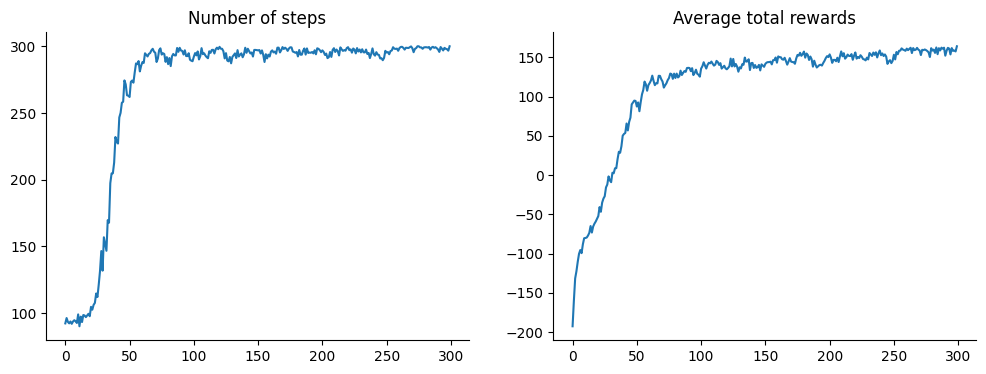

In [10]:
num_steps = []
total_rewards = []
for episode in range(num_episodes):
    # Train for one episode
    simple_model.train()
    episode_summary = train_for_one_episode(
        vec_env,
        model=simple_model,
        optimizer=optimizer,
        max_steps=max_steps,
        device=device,
    )
    num_steps.append(episode_summary.num_steps.mean())
    total_rewards.append(episode_summary.total_rewards.mean())

    # Decay learning rate
    for param_group in optimizer.param_groups:
        param_group["lr"] = learning_rate_schedule[episode]

    # Report progress
    result_frequency = ", ".join(
        f"{k}: {v:>4.0%}" for k, v in episode_summary.result_frequency.items()
    )
    print(
        f"{episode + 1:>3} | "
        f"avg steps: {np.mean(num_steps[-save_freq:]):>3.0f} | "
        f"avg reward: {np.mean(total_rewards[-save_freq:]):>6.1f} | "
        f"{result_frequency}",
        flush=True,
        end="\r",
    )
    if (episode + 1) % save_freq == 0:
        print()

# Plot the training progress
_, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(num_steps)
axs[0].set_title("Number of steps")
axs[0].spines["right"].set_visible(False)
axs[0].spines["top"].set_visible(False)

axs[1].plot(total_rewards)
axs[1].set_title("Average total rewards")
axs[1].spines["right"].set_visible(False)
axs[1].spines["top"].set_visible(False)

# Save Model

In [17]:
# Sign and save the model to local directory
env_config = dotenv_values()

sign_n_save_model(
    model=simple_model.cpu(),
    destination="../models/lunar-lander",
    keypair=load_keypair("../models/private.pem", env_config["MODEL_KEY_PASSWORD"]),
    overwrite=True,
)

# Load and evaluate model

In [2]:
# Load model
lunar_lander: SimplePolicyNet = load_n_verify_model("../models/lunar-lander")
lunar_lander.eval()

# Evaluate the model
env_id = "LunarLander-v2"
num_episodes = 30
eval_env = Monitor(gym.make("LunarLander-v2"))
mean_reward, std_reward = evaluate_policy(
    lunar_lander, eval_env, n_eval_episodes=num_episodes, deterministic=True
)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

eval_stats = {
    "env_id": env_id,
    "num_episodes": num_episodes,
    "mean_reward": mean_reward,
    "std_reward": std_reward,
}

with open("../models/lunar-lander/eval_results.json", "w") as f:
    json.dump(eval_stats, f, indent=2)

mean_reward=252.82 +/- 16.283324630001893


## Capture replay

In [24]:
rewards = capture_replay(
    env=gym.make("LunarLander-v2", render_mode="rgb_array"),
    action_func=lunar_lander.get_action,
    video_folder="../models/lunar-lander",
    max_steps=500,
)
print(f"Total steps: {len(rewards)}\nTotal reward: {sum(rewards)}")